In [77]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

In [78]:
# Dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Definir as classes
classes = [0, 1, 8]
nomes_classes = {0: 'airplane', 1: 'automobile', 8: 'ship'}

# Filtrar o conjunto de dados para conter apenas as classes de interesse
def filtra_classes(x, y, classes):
    index_filter = np.isin(y, classes)
    x, y = x[index_filter.squeeze()], y[index_filter.squeeze()]
    return x, y

x_train, y_train = filtra_classes(x_train, y_train, classes)
x_test, y_test = filtra_classes(x_test, y_test, classes)

In [79]:
# Mapear os labels para índices de 0 a 2
for index, classe in enumerate(classes):
    y_train[y_train == classe] = index
    y_test[y_test == classe] = index

# Normalização 0 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode os labels
y_train = to_categorical(y_train, 3)
y_test_onehot = to_categorical(y_test, 3)

# Criar um conjunto de validação (20%)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [80]:
# Modelo VGG16 pré-treinado sem as camadas de classificação finais
modelo_pre = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in modelo_pre.layers:
    layer.trainable = False

# Adicionar as novas camadas
x = Flatten()(modelo_pre.output)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # 3 classes de saída

modelo = Model(inputs=modelo_pre.input, outputs=x)
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
#D. Augmentation
train_da = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Ajustar o gerador de dados para treinamento
train_gen = train_da.flow(x_train, y_train, batch_size=32)

In [82]:
# Treinar o modelo
history = modelo.fit(
    train_gen,
    epochs=25,
    validation_data=(x_val, y_val)
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 201s 532ms/step - accuracy: 0.6481 - loss: 0.7777 - val_accuracy: 0.8057 - val_loss: 0.5136
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 197s 525ms/step - accuracy: 0.7468 - loss: 0.6055 - val_accuracy: 0.7963 - val_loss: 0.5191
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 529ms/step - accuracy: 0.7673 - loss: 0.5698 - val_accuracy: 0.8187 - val_loss: 0.4695
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 200s 533ms/step - accuracy: 0.7760 - loss: 0.5487 - val_accuracy: 0.8207 - val_loss: 0.4688
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 524ms/step - accuracy: 0.7807 - loss: 0.5331 - val_accuracy: 0.8070 - val_loss: 0.4837
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 196s 523ms/step - accuracy: 0.7854 - loss: 0.5245 - val_accuracy: 0.8243 - val_loss: 0.4543
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 197s 526ms/step - accuracy: 0.8006 - loss: 0.4971 - val_accuracy: 0.8297 - val_loss: 0.4425
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 195s 521ms/step - accuracy: 0.7971 - loss: 0.50

In [83]:
# Avaliar o modelo no conjunto de teste
test_loss, test_acc = modelo.evaluate(x_test, y_test_onehot)
print(f"Acc - teste: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 403ms/step - accuracy: 0.8350 - loss: 0.4270
Acc - teste: 0.8330


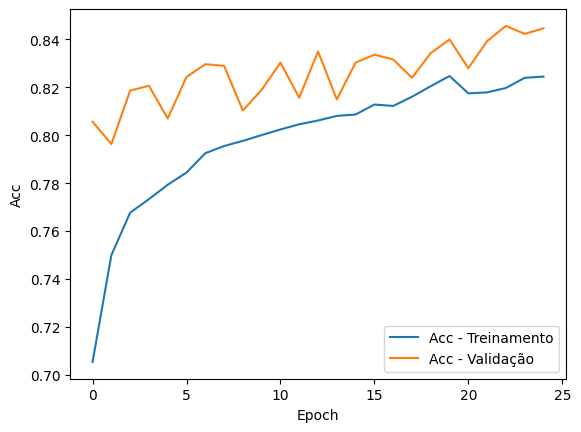

In [84]:
# Plotar as curvas de aprendizado
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acc - Treinamento')
plt.plot(history.history['val_accuracy'], label='Acc - Validação')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.show()


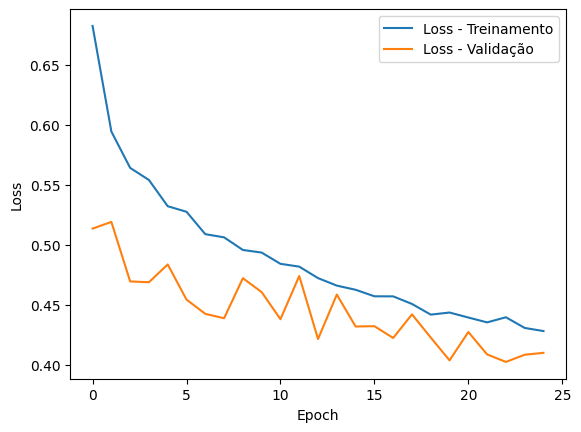

In [85]:
plt.plot(history.history['loss'], label='Loss - Treinamento')
plt.plot(history.history['val_loss'], label='Loss - Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [86]:
# Dados para CM
y_pred = modelo.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.squeeze()

94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step


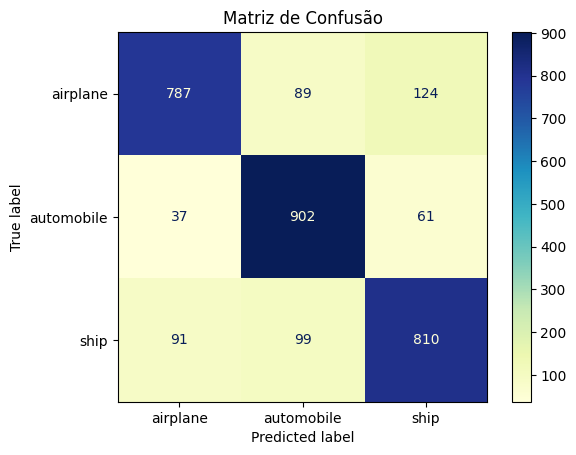

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[nomes_classes[i] for i in classes])
disp.plot(cmap=plt.cm.YlGnBu)
plt.title('Matriz de Confusão')
plt.show()